In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import skew
from sklearn import preprocessing
import pandas as pd
import networkx as nx
import seaborn as sns
from scipy.linalg import eigh
import math
import random
import tsaug
from tqdm import tqdm
df = pd.read_json('../data/processed/realData.json', orient='records', lines=True)

print(df)

           class                                          file_path      exam  \
0        Healthy  ../data/raw/COP_Tests/HG\participant_21\OASETD...    OASETD   
1        Healthy  ../data/raw/COP_Tests/HG\participant_21\OASE_S...      OASE   
2        Healthy  ../data/raw/COP_Tests/HG\participant_21\OASITD...    OASITD   
3        Healthy  ../data/raw/COP_Tests/HG\participant_21\OCSETD...    OCSETD   
4        Healthy  ../data/raw/COP_Tests/HG\participant_21\OCSE_S...      OCSE   
..           ...                                                ...       ...   
428  Neuropathic  ../data/raw/COP_Tests/DNG\participant_20\EBOCT...    EBOCTD   
429  Neuropathic  ../data/raw/COP_Tests/DNG\participant_20\EBOCT...    EBOCTD   
430  Neuropathic  ../data/raw/COP_Tests/DNG\participant_20\EBOCT...  EBOCTDSI   
431  Neuropathic  ../data/raw/COP_Tests/DNG\participant_20\EBOCT...  EBOCTDSI   
432  Neuropathic  ../data/raw/COP_Tests/DNG\participant_20\EBOCT...  EBOCTDSI   

                           

In [3]:
x = df.iloc[0].cop_x

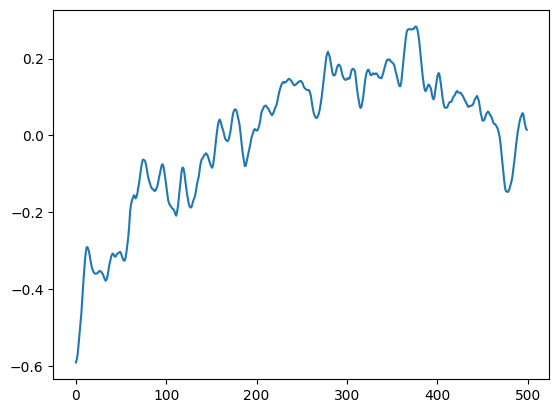

In [4]:
plt.plot(x)

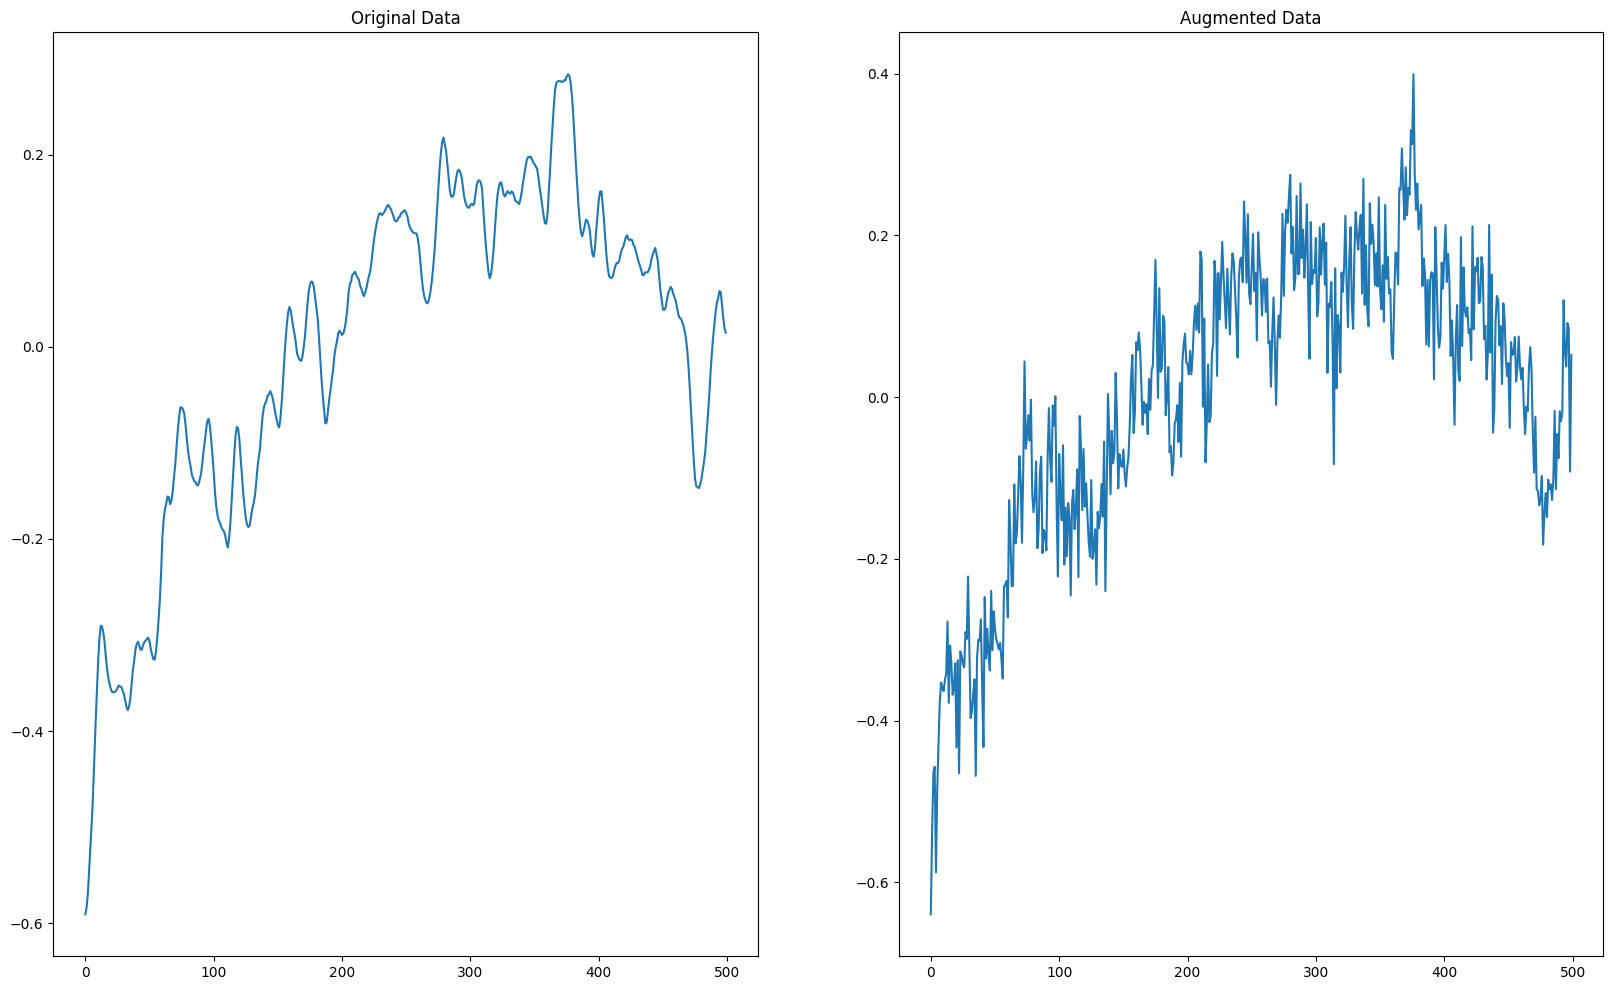

In [5]:
def add_gaussian_noise(time_series, mean=0.0, stddev=1.0):
    """
    Adds Gaussian noise to a time series.

     Options:
     time_series (array-like): A time series to which noise is added.
     mean (float): The average value of the noise. Default is 0.0.
     stddev (float): Standard deviation of noise. Default is 1.0.

     Returns:
     noisy_series (np.array): Time series with added noise.
     """
     # Gaussian noise generation
    noise = np.random.normal(mean, stddev, len(time_series))

    # Adding noise to the original time series
    noisy_series = time_series + noise

    return noisy_series

augmented_time_series_data = add_gaussian_noise(df.iloc[0].cop_x, mean=0.0, stddev=0.05)

plt.figure(figsize=(20, 12))

plt.subplot(1,2,1)
plt.title("Original Data")
plt.plot(df.iloc[0].cop_x)

plt.subplot(1,2,2)
plt.title("Augmented Data")
plt.plot(augmented_time_series_data)

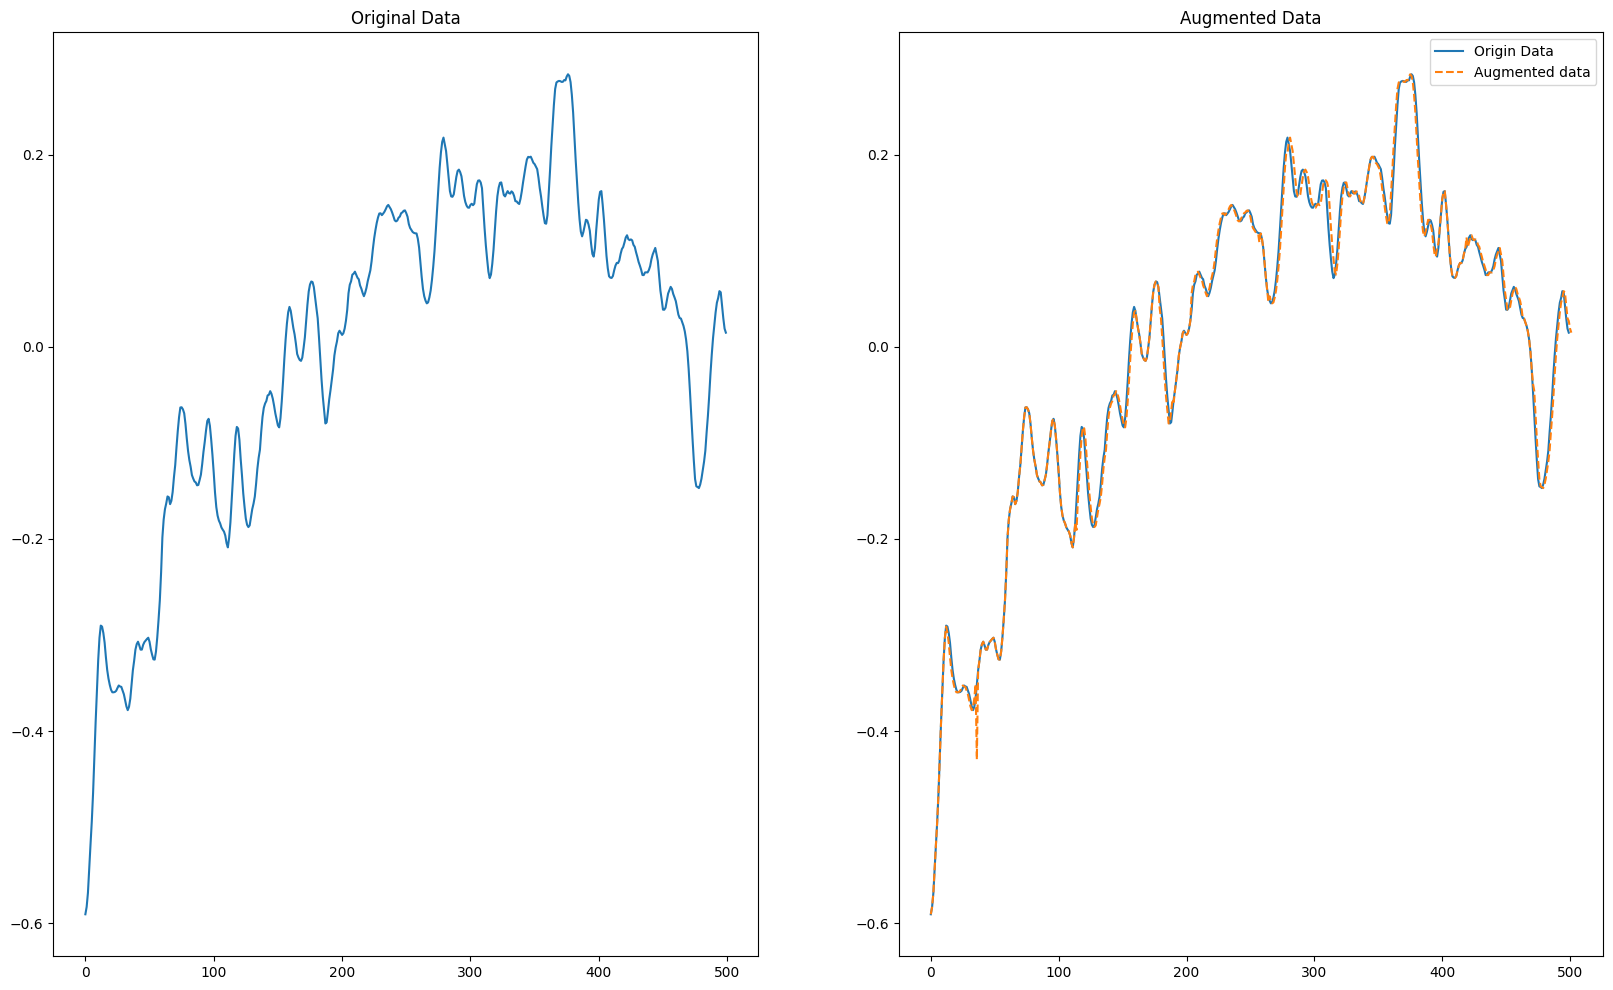

In [6]:
def time_warping(time_series, num_operations=10, warp_factor=0.2):
    """
    Applying time warping to a time series.

    :param time_series: Time series, numpy array.
    :param num_operations: Number of insert/delete operations.
    :param warp_factor: Warp factor that determines the impact of operations.
    :return: Distorted time series.
    """
    warped_series = time_series.copy()
    for _ in range(num_operations):
        operation_type = random.choice(["insert", "delete"])
        index = random.randint(1, len(warped_series) - 2)
        if operation_type == "insert":
            # Insert a value by interpolating between two adjacent points
            insertion_value = (warped_series[index - 1] + warped_series[index]) * 0.5
            warp_amount = insertion_value * warp_factor * random.uniform(-1, 1)
            warped_series = np.insert(warped_series, index, insertion_value + warp_amount)
        elif operation_type == "delete":
            # Remove a random point
            warped_series = np.delete(warped_series, index)
        else:
            raise ValueError("Invalid operation type")

    return warped_series

augmented_time_series_data = time_warping(df.iloc[0].cop_x, num_operations=20, warp_factor=0.25)
plt.figure(figsize=(20, 12))

plt.subplot(1,2,1)
plt.title("Original Data")
plt.plot(df.iloc[0].cop_x[:])

plt.subplot(1,2,2)
plt.title("Augmented Data")
plt.plot(df.iloc[0].cop_x[:], label="Origin Data")
plt.plot(augmented_time_series_data, label="Augmented data", linestyle="--")
plt.legend()


C:\Users\nicol\AppData\Local\Temp\ipykernel_22004\3938808522.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


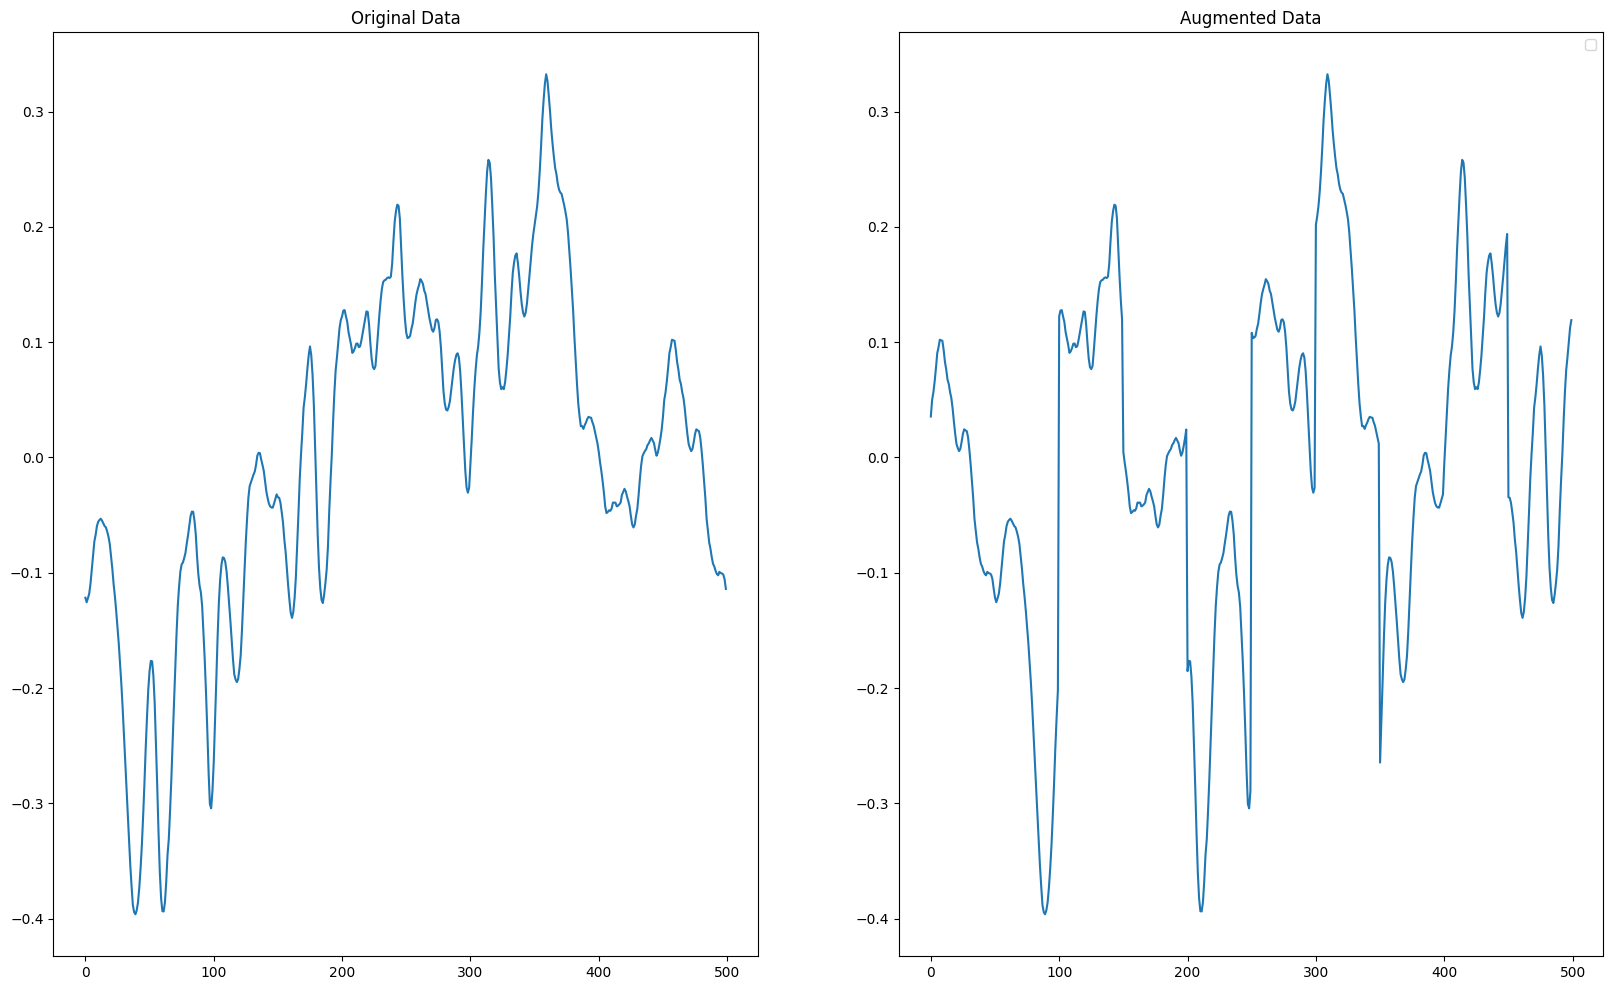

In [7]:
def shuffle_time_slices(time_series, slice_size=1):
    """
    Shuffle different time slices of the provided array.

    Parameters:
    time_series (array-like): An array containing time-series data.
    slice_size (int): The size of each time slice that will be shuffled.

    Returns:
    shuffled_data (array-like): The array with shuffled time slices.
    """

    # Convert to numpy array if not already
    time_series = np.array(time_series)

    if slice_size <= 0 or slice_size > len(time_series):
        raise ValueError("Slice size must be within the range 1 to len(data)")

    num_slices = len(time_series) // slice_size

    # Cut the data into slices
    slices = [time_series[i * slice_size:(i + 1) * slice_size] for i in range(num_slices)]

    # Shuffle the slices
    np.random.shuffle(slices)

    # Concatenate the shuffled slices
    shuffled_data = np.concatenate(slices)

    # Include any leftover data that couldn't form a complete slice
    remainder = len(time_series) % slice_size
    if remainder > 0:
        remainder_data = time_series[-remainder:]
        shuffled_data = np.concatenate([shuffled_data, remainder_data])

    return shuffled_data

augmented_time_series_data = shuffle_time_slices(df.iloc[1].cop_x, slice_size=50)
plt.figure(figsize=(20, 12))

plt.subplot(1,2,1)
plt.title("Original Data")
plt.plot(df.iloc[1].cop_x[:])

plt.subplot(1,2,2)
plt.title("Augmented Data")
plt.plot(augmented_time_series_data)
plt.legend()


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def find_period(time_series, sampling_rate):
    """
    Encuentra el período dominante en una serie de tiempo utilizando la Transformada Rápida de Fourier (FFT).
    
    Args:
        time_series (np.array): Serie de tiempo.
        sampling_rate (float): Tasa de muestreo de la serie de tiempo (puntos por unidad de tiempo).
        
    Returns:
        float: Estimación del período dominante en la serie de tiempo.
    """
    # Aplicar la FFT a la serie de tiempo
    fft_values = np.fft.fft(time_series)
    fft_freq = np.fft.fftfreq(len(time_series), d=1/sampling_rate)
    
    # Encontrar el índice del máximo valor en la FFT (excluyendo el primer valor que es la frecuencia DC)
    max_index = np.argmax(np.abs(fft_values[1:])) + 1  # +1 para compensar el índice omitido
    
    # Calcular la frecuencia y el período correspondientes al máximo valor en la FFT
    dominant_freq = fft_freq[max_index]
    dominant_period = 1 / dominant_freq
    
    return dominant_period

def stl_time_series_augmentation(time_series, num_augmented_samples, seasonal=True, trend=True, noise=True, period=None):
    """
    Aumenta una serie de tiempo utilizando el método STL (Seasonal and Trend decomposition using Loess).
    
    Args:
        time_series (np.array): Serie de tiempo original.
        num_augmented_samples (int): Número de muestras aumentadas a generar.
        seasonal (bool): Indica si se debe modificar la componente estacional.
        trend (bool): Indica si se debe modificar la componente de tendencia.
        noise (bool): Indica si se debe agregar ruido a la serie de tiempo aumentada.
        period (int): Período de estacionalidad de la serie de tiempo.
        
    Returns:
        np.array: Arreglo 2D que contiene las series de tiempo aumentadas.
    """
    augmented_series = []
    for _ in range(num_augmented_samples):
        # Obtener el período dominante utilizando Fourier
        if period is None:
            period = find_period(time_series, len(time_series))
        
        # Descomponer la serie de tiempo original utilizando STL
        stl = STL(time_series, period=period)
        result = stl.fit()
        
        # Modificar los componentes según las indicaciones
        modified_seasonal = result.seasonal + np.random.normal(scale=0.1, size=len(time_series)) if seasonal else result.seasonal
        modified_trend = result.trend + np.random.normal(scale=0.1, size=len(time_series)) if trend else result.trend
        modified_residuals = result.resid + np.random.normal(scale=0.1, size=len(time_series)) if noise else result.resid
        
        # Reconstruir la serie de tiempo aumentada
        augmented_series.append(modified_seasonal + modified_trend + modified_residuals)
    
    return np.array(augmented_series)

# Ejemplo de uso
original_time_series = df.iloc[0].cop_x  # Serie de tiempo original (en este caso, una onda sinusoidal)
num_augmented_samples = 5  # Número de muestras aumentadas a generar

# Obtener el período dominante utilizando Fourier
sampling_rate = len(original_time_series) / len(df)  # Tasa de muestreo
period = find_period(original_time_series, sampling_rate)
print(period)
# Generar las series de tiempo aumentadas utilizando STL y el período dominante obtenido
augmented_series = stl_time_series_augmentation(original_time_series, num_augmented_samples, period=int(period))

# Seleccionar una de las series de tiempo aumentadas para mostrar junto a la original
augmented_series_to_show = augmented_series[0]

# Visualizar la serie de tiempo original y la serie de tiempo aumentada seleccionada
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(original_time_series, label='Original', color='blue')
plt.title('Serie de Tiempo Original')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

plt.subplot(1, 2, 2)
plt.plot(augmented_series_to_show, label='Aumentada', color='green')
plt.title('Serie de Tiempo Aumentada')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

plt.tight_layout()
plt.show()


433.0000000000001


NameError: name 'STL' is not defined

In [ ]:
pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.8 MB 1.3 MB/s eta 0:00:08
   -- ------------------------------------- 0.5/9.8 MB 4.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.3/9.8 MB 8.3 MB/s eta 0:00:02
   ----------------- ---------------------- 4.2/9.8 MB 20.6 MB/s eta 0:00:01
   ----------------- ---------------------- 4.2/9.8 MB 20.6 MB/s eta 0:00:01
   ----------------- ---------------------- 4.2/9.8 MB 20.6 MB/s eta 0:00:01
   ------------------------ --------------- 6.0/9.8 MB 18.1 MB/s eta 0:00:01
   -------------------------------- ------- 7.9/9.8 MB 20.3 MB/s eta 0:00:01
   ---------------------------------------  9.6/9.8 MB 21.9 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 20.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.9 kB ? eta -:--:--
   ---------------------

Período dominante estimado: 1.0


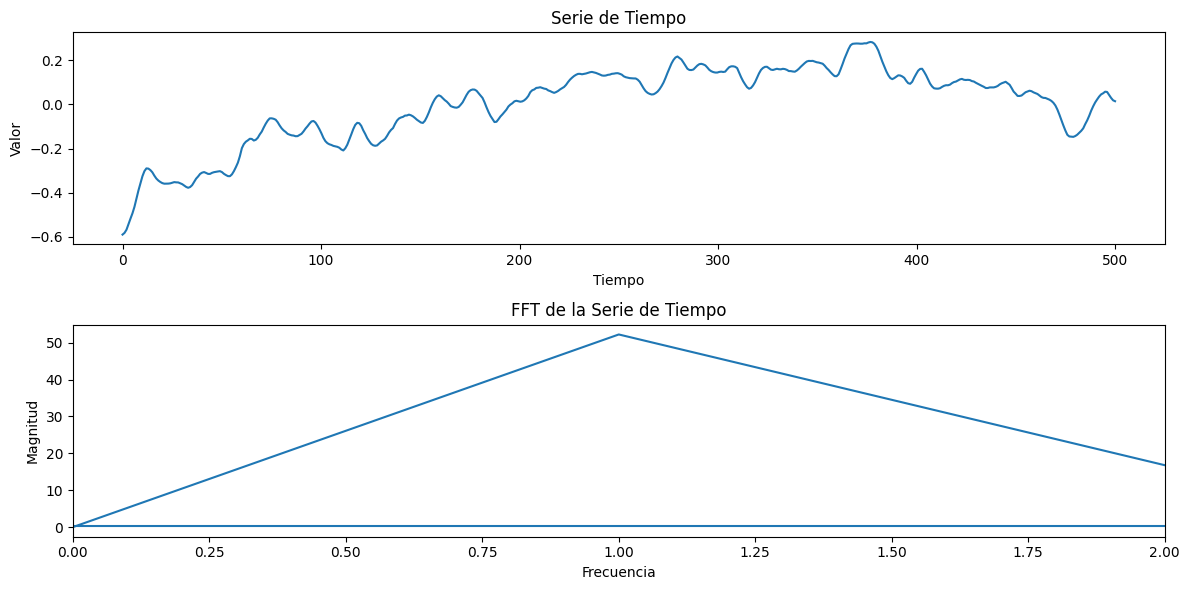

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def find_period(time_series, sampling_rate):
    """
    Encuentra el período dominante en una serie de tiempo utilizando la Transformada Rápida de Fourier (FFT).
    
    Args:
        time_series (np.array): Serie de tiempo.
        sampling_rate (float): Tasa de muestreo de la serie de tiempo (puntos por unidad de tiempo).
        
    Returns:
        float: Estimación del período dominante en la serie de tiempo.
    """
    # Aplicar la FFT a la serie de tiempo
    fft_values = np.fft.fft(time_series)
    fft_freq = np.fft.fftfreq(len(time_series), d=1/sampling_rate)
    
    # Encontrar el índice del máximo valor en la FFT (excluyendo el primer valor que es la frecuencia DC)
    max_index = np.argmax(np.abs(fft_values[1:])) + 1  # +1 para compensar el índice omitido
    
    # Calcular la frecuencia y el período correspondientes al máximo valor en la FFT
    dominant_freq = fft_freq[max_index]
    dominant_period = 1 / dominant_freq
    
    return dominant_period

# Generar una serie de tiempo de ejemplo (por ejemplo, una sinusoide)
t = np.linspace(0, 500, 500)  # Tiempo de 0 a 10 con 1000 puntos
time_series = df.iloc[0].cop_x  # Sinusoide con frecuencia de 0.5 Hz

# Calcular el período dominante
sampling_rate = 500  # Tasa de muestreo
dominant_period = find_period(time_series, sampling_rate)
print("Período dominante estimado:", dominant_period)

# Calcular fft
fft_values = np.fft.fft(time_series)
fft_freq = np.fft.fftfreq(len(time_series), d=1/sampling_rate)

# Visualizar la serie de tiempo y la FFT
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, time_series)
plt.title('Serie de Tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

plt.subplot(2, 1, 2)
plt.plot(fft_freq, np.abs(fft_values))
plt.title('FFT de la Serie de Tiempo')
plt.xlabel('Frecuencia')
plt.ylabel('Magnitud')
plt.xlim(0, 2)  # Limitar el rango de frecuencia para mayor claridad

plt.tight_layout()
plt.show()
